## Seafloor mapping combining a timelapse photos and gps track

Load gps track and series of photos, tie the two together based on the time recorded by gps and photos and save as a kml file. 

You can also apply a time correction in case the time on the gps device or camera was incorrect.

This notebook was developed to combine gopro timelapse photos of the seafloor of a hydrothermally active area at the coast of Guadeloupe with a gps track from a device that was towed along above water.

## import modules

In [1]:
import math
import os
from datetime import datetime

import gpxpy
import exifread
import natsort
import pytz
import simplekml
import rasterio

import numpy as np
import matplotlib.pyplot as pl
import geopandas as gp

## Some filenames and parameters

In [2]:
# gps file name
fng = 'gps_track/track_mapping_tahiti_11aug19.gpx'

# directroy with timelapse photos
photo_dir = '/Volumes/Transcend/photogrammetry/seafloor_photos/time_lapse_11aug2019'
#photo_dir = '/Volumes/Transcend/photogrammetry/seafloor_photos/first_100_photos_11aug2019'

# timezone of photos & gps track
timezone = "America/Guadeloupe"

# Bathymetry file
# this is used to calculate depth and the size of the photo overlays
fn_bathy = 'bathymetry/bathy5m_Clip.img'

# correct the time of the gopro using a reference photo and gps point
# use this in case the time on your gps device and gopro dont match
correct_gopro_time = True

# reference gps pt and photo name for same loc
# this is used to correct time offset between gps and gopro photos
ref_gps_pt = 132*2
ref_photo_name = 'G0042060.JPG'

# first and last photo to include in kml files:
first_photo = 'G0041992.JPG'
last_photo = 'G0042657.JPG'

# coordinate ref system to use for calculating distances
# this should be an equal area projection, such as UTM
# The bathymetry file is also assumed to use this projection
target_epsg = 32620

# interval for photos in overlay
# ie, if this is set to 10 then only one in every 10 photos will be included
photo_interval = 7

# anlge of view of photos
# note info from hero 7 webpage, no info on 8 found, but camera didnt change probably
fov_angle_x = 122.6 / 2.0
fov_angle_y = 94.4 / 2.0

# photo tilt angle:
tilt = 90.0

# filenames for kml files:
output_kml_file = 'gps_track_with_photos_11aug19'
doc_name = 'seafloor_mapping_bouillante_11aug19'
kml_overlay_file = 'gps_track_with_overlay_11aug19'

## Load gps data and extract time and coordinates

In [3]:
gpx_file = open(fng, 'r')
gpx = gpxpy.parse(gpx_file)

In [4]:
gps_xys = []
gps_times = []
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            gps_xys.append([point.latitude, point.longitude])
            gps_times.append(point.time)
gps_xy = np.array(gps_xys)

##  Make a figure of the track and the reference pt:

time just before first turn =  2019-08-11 16:11:18+00:00


(16.136629, 16.137414)

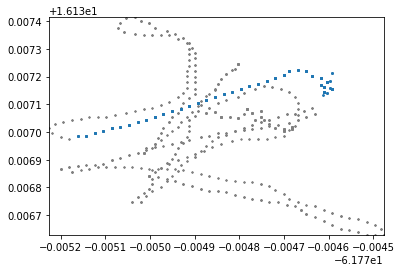

In [5]:
xy_at_turn = gps_xy[ref_gps_pt]
gps_time_at_turn = gps_times[ref_gps_pt]
print('time just before first turn = ', gps_time_at_turn)

fig, ax = pl.subplots(1, 1)

ax.scatter(gps_xy[:, 1], gps_xy[:, 0], s=1, color='gray')
ax.scatter(gps_xy[:ref_gps_pt, 1], gps_xy[:ref_gps_pt, 0], s=3)

ax.set_xlim(gps_xy[:, 1].min(), gps_xy[:, 1].max())
ax.set_ylim(gps_xy[:, 0].min(), gps_xy[:, 0].max())



## Load seafloor photos

In [6]:
photo_fns = os.listdir(photo_dir)
photo_fns_full = [os.path.join(photo_dir, photo_fn) for photo_fn in photo_fns]
pfns = natsort.natsorted(photo_fns_full)
pfns_clipped = [os.path.split(pfn)[-1] for pfn in pfns]


if first_photo in pfns_clipped:
    id1 = pfns_clipped.index(first_photo)
else:
    id1 = 0
    
if last_photo in pfns_clipped:
    id2 = pfns_clipped.index(last_photo)
else:
    id2 = -1
    
pfns = pfns[id1:id2]
pfns_clipped = pfns_clipped[id1:id2]
photo_fns_full = photo_fns_full[id1:id2]
photo_fns = photo_fns[id1:id2]

## Extract time from photos

In [7]:

ptimes_original = []

print('extracting times from seafloor photos')

for pfn in pfns:
    #'EXIF DateTimeOriginal'
    tags = exifread.process_file(open(pfn, 'rb')) 
    t = tags['EXIF DateTimeOriginal']
    T = datetime.strptime(str(t), '%Y:%m:%d %H:%M:%S')
    
    #data = gpsphoto.getGPSData(pfn)
    #ptimes.append(data['UTC-Time'])
    
    local = pytz.timezone(timezone)
    local_dt = local.localize(T, is_dst=None)
    utc_dt = local_dt.astimezone(pytz.utc)
    
    ptimes_original.append(utc_dt)

print('done')

extracting times from seafloor photos
done


## Correct time for gopro photos

The time of the gopro photos is corrected by comparing the time for a reference photo and corresponding point in the gps track, which are defined in the filenames and parameters part of this notebook

In [9]:
if correct_gopro_time is True:
    print('correcting time for gopro photos')
    photo_at_turn = pfns_clipped.index(ref_photo_name)

    print('photo number at turn = %i' % photo_at_turn)

    photo_time_at_turn = ptimes_original[photo_at_turn]
    photo_time_at_turn

    dt = gps_time_at_turn - photo_time_at_turn
    ptimes = [p + dt for p in ptimes_original]

    print('print first and last times for photos: ', ptimes[0], ptimes[-1])
    print('corrected photo time for turn = ', ptimes[photo_at_turn])
    print('gps point time just before turn = ', gps_time_at_turn)

    print(pfns_clipped[photo_at_turn], gps_xy[ref_gps_pt])
    
else:
    ptimes = ptimes_original

correcting time for gopro photos
photo number at turn = 68
print first and last times for photos:  2019-08-11 16:09:02+00:00 2019-08-11 16:31:10+00:00
corrected photo time for turn =  2019-08-11 16:11:18+00:00
gps point time just before turn =  2019-08-11 16:11:18+00:00
G0042060.JPG [ 16.136984 -61.775162]


## Find nearest GPS point for each photo

In [10]:
def nearest_ind(time_list, target_time):
    return np.argmin(np.array([np.abs((t - target_time).total_seconds()) for t in time_list]))

gps_ind = []
for i, ptime in enumerate(ptimes):
    ne = nearest_ind(gps_times, ptime)
    gps_ind.append(ne)
    
gps_ind_a = np.array(gps_ind)

## Make a list of gopro photos for each GPS point

In [11]:
photo_list = []
photos_first = []
photos_last = []
for i in range(len(gps_xy)):
    nd = np.where(gps_ind_a==i)[0]
    
    if len(nd) > 0:
        photo_list.append(nd)
        photos_first.append(pfns_clipped[nd[0]])
        photos_last.append(pfns_clipped[nd[-1]])
    else:
        photo_list.append(None)
        photos_first.append(None)
        photos_last.append(None)

## Generate a csv file with all gps locations and photos

In [12]:
import pandas as pd

cols = ['time', 'lat', 'long', 'gopro_photo_first', 'gopro_photo_last']
ind = np.arange(len(gps_times))
df = pd.DataFrame(index=ind, columns=cols)

df['time'] = gps_times
df['lat'] = gps_xy[:, 0]
df['long'] = gps_xy[:, 1]

df['gopro_photo_first'] = photos_first
df['gopro_photo_last'] = photos_last

## Save gps track with photo names to csv file

In [13]:
fn_out = 'output/gps_track_11_aug_with_photo_ind.csv'
print('saving csv file as %s' % fn_out)
df.to_csv(fn_out)

saving csv file as output/gps_track_11_aug_with_photo_ind.csv


## Make a new csv file with one gps pt for each photo:

In [14]:
cols = ['gopro_photo_file', 'time', 'lat', 'long', 'x_utm', 'y_utm', 'dx', 'dy', 'distance',
        'direction', 'estimated_depth', 'estimated_fov']

index = pfns_clipped
dfp = pd.DataFrame(columns=cols, index=index)

dfp['gopro_photo_file'] = pfns
dfp['time'] = ptimes

photo_gps_ind = []
for i, ptime in enumerate(ptimes):
    ne = nearest_ind(gps_times, ptime)
    photo_gps_ind.append(ne)
    
#gps_ind_a = np.array(phogps_ind)

dfp['lat'] = [gps_xy[i][0] for i in photo_gps_ind]
dfp['long'] = [gps_xy[i][1] for i in photo_gps_ind]

dfp.head()


,gopro_photo_file,time,lat,long,x_utm,y_utm,dx,dy,distance,direction,estimated_depth,estimated_fov
G0041992.JPG,/Volumes/Transcend/photogrammetry/seafloor_pho...,2019-08-11 16:09:02+00:00,16.137219,-61.774688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
G0041993.JPG,/Volumes/Transcend/photogrammetry/seafloor_pho...,2019-08-11 16:09:04+00:00,16.137219,-61.774688,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
G0041994.JPG,/Volumes/Transcend/photogrammetry/seafloor_pho...,2019-08-11 16:09:06+00:00,16.137205,-61.774701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
G0041995.JPG,/Volumes/Transcend/photogrammetry/seafloor_pho...,2019-08-11 16:09:08+00:00,16.137205,-61.774701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
G0041996.JPG,/Volumes/Transcend/photogrammetry/seafloor_pho...,2019-08-11 16:09:10+00:00,16.137205,-61.774701,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Convert to UTM zone 20N (EPSG 32620)

In [15]:
from shapely.geometry import Point

coords = list(zip(dfp['long'].values, dfp['lat'].values))
dfp['coordinates'] = coords
dfp['coordinates'] = dfp['coordinates'].apply(Point)

gd = gp.GeoDataFrame(dfp, geometry='coordinates')

# set initial crs to WGS84 (lat/long)
gd.crs = {'init' :'epsg:4326'}

# convert to UTM
gdu = gd.to_crs(epsg=target_epsg)

# read new coordinates
gdu['x_utm'] = gdu.geometry.x
gdu['y_utm'] = gdu.geometry.y
gdu.head()

,gopro_photo_file,time,lat,long,x_utm,y_utm,dx,dy,distance,direction,estimated_depth,estimated_fov,coordinates
G0041992.JPG,/Volumes/Transcend/photogrammetry/seafloor_pho...,2019-08-11 16:09:02+00:00,16.137219,-61.774688,631016.711602,1.784503e+06,NaN,NaN,NaN,NaN,NaN,NaN,POINT (631016.7116016573 1784503.293169191)
G0041993.JPG,/Volumes/Transcend/photogrammetry/seafloor_pho...,2019-08-11 16:09:04+00:00,16.137219,-61.774688,631016.711602,1.784503e+06,NaN,NaN,NaN,NaN,NaN,NaN,POINT (631016.7116016573 1784503.293169191)
G0041994.JPG,/Volumes/Transcend/photogrammetry/seafloor_pho...,2019-08-11 16:09:06+00:00,16.137205,-61.774701,631015.330602,1.784502e+06,NaN,NaN,NaN,NaN,NaN,NaN,POINT (631015.3306018645 1784501.735981411)
G0041995.JPG,/Volumes/Transcend/photogrammetry/seafloor_pho...,2019-08-11 16:09:08+00:00,16.137205,-61.774701,631015.330602,1.784502e+06,NaN,NaN,NaN,NaN,NaN,NaN,POINT (631015.3306018645 1784501.735981411)
G0041996.JPG,/Volumes/Transcend/photogrammetry/seafloor_pho...,2019-08-11 16:09:10+00:00,16.137205,-61.774701,631015.330602,1.784502e+06,NaN,NaN,NaN,NaN,NaN,NaN,POINT (631015.3306018645 1784501.735981411)


## Read bathymetry file

In [16]:
# Open the raster and store metadata
src = rasterio.open(fn_bathy)

coords_utm = list(zip(gdu['x_utm'].values, gdu['y_utm'].values))

# Sample the raster at every point location and store values in DataFrame
gdu['estimated_depth'] = [x[0] for x in src.sample(coords_utm)]

gdu['estimated_depth'].describe()

not_ok = gdu['estimated_depth'] < -15.0
gdu.loc[not_ok, 'estimated_depth'] = np.median(gdu['estimated_depth'])

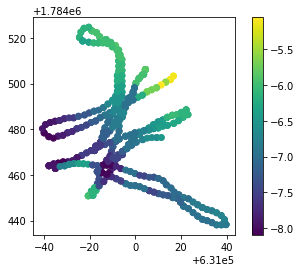

In [17]:
gdu.plot(column='estimated_depth', legend=True)

## Calculate direction of photos

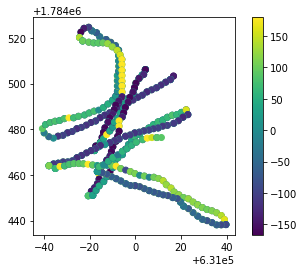

In [18]:
x = gdu['x_utm'].values
y = gdu['y_utm'].values

dx = np.zeros_like(x)
dy = np.zeros_like(y)

dx[1:-1] = np.diff(x, n=2)
dx[0] = dx[1]
dx[-1] = dx[-2]

dy[1:-1] = np.diff(y, n=2)
dy[0] = dy[1]
dy[-1] = dy[-2]

gdu['dx'] = dx
gdu['dy'] = dy
gdu['distance'] = np.sqrt(dx**2 + dy**2)
gdu['angle_rad'] = np.arctan2(dx, dy)
gdu['angle'] = np.rad2deg(np.arctan2(dx, dy))

# calculate angles in degrees as well
dx_ll = np.zeros_like(x)
dy_ll = np.zeros_like(x)

dx_ll[1:-1] = np.diff(gdu['long'], n=2)
dx_ll[0] = dx_ll[1]
dx_ll[-1] = dx_ll[-2]

dy_ll[1:-1] = np.diff(gdu['lat'], n=2)
dy_ll[0] = dy_ll[1]
dy_ll[-1] = dy_ll[-2]

gdu['angle_ll_rad'] = np.arctan2(dx_ll, dy_ll)
gdu['angle_ll'] = np.rad2deg(gdu['angle_ll_rad'])

gdu.plot(column='angle', legend=True)

## Save csv with photos, coordiates and headings file

In [19]:
fn_out = 'output/gopro_photos_with_coords.csv'
print('saving csv file as %s' % fn_out)
gdu.to_csv(fn_out, index_label='gopro_photo')

saving csv file as output/gopro_photos_with_coords.csv


## Cut out all photos with zero distance

In [20]:
ind = gdu['distance'] > 0
gdu2 = gdu.loc[ind]
gdu2.head()

,gopro_photo_file,time,lat,long,x_utm,y_utm,dx,dy,distance,direction,estimated_depth,estimated_fov,coordinates,angle_rad,angle,angle_ll_rad,angle_ll
G0041992.JPG,/Volumes/Transcend/photogrammetry/seafloor_pho...,2019-08-11 16:09:02+00:00,16.137219,-61.774688,631016.711602,1.784503e+06,-1.381000,-1.557188,2.081344,NaN,-5.11,NaN,POINT (631016.7116016573 1784503.293169191),-2.416088,-138.431624,-2.393215,-137.121096
G0041993.JPG,/Volumes/Transcend/photogrammetry/seafloor_pho...,2019-08-11 16:09:04+00:00,16.137219,-61.774688,631016.711602,1.784503e+06,-1.381000,-1.557188,2.081344,NaN,-5.11,NaN,POINT (631016.7116016573 1784503.293169191),-2.416088,-138.431624,-2.393215,-137.121096
G0041994.JPG,/Volumes/Transcend/photogrammetry/seafloor_pho...,2019-08-11 16:09:06+00:00,16.137205,-61.774701,631015.330602,1.784502e+06,1.381000,1.557188,2.081344,NaN,-5.11,NaN,POINT (631015.3306018645 1784501.735981411),0.725505,41.568376,0.748378,42.878904
G0041998.JPG,/Volumes/Transcend/photogrammetry/seafloor_pho...,2019-08-11 16:09:14+00:00,16.137205,-61.774701,631015.330602,1.784502e+06,-2.025265,-1.118453,2.313576,NaN,-5.11,NaN,POINT (631015.3306018645 1784501.735981411),-2.075365,-118.909670,-2.055274,-117.758541
G0041999.JPG,/Volumes/Transcend/photogrammetry/seafloor_pho...,2019-08-11 16:09:16+00:00,16.137195,-61.774720,631013.305337,1.784501e+06,2.025265,1.118453,2.313576,NaN,-5.56,NaN,POINT (631013.3053366056 1784500.617528911),1.066227,61.090330,1.086318,62.241459


## Estimate field of view for photos

In [21]:
def haversine(lon1, lat1, lon2, lat2):

    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    https://stackoverflow.com/questions/4913349/haversine-formula-in-python-bearing-and-distance-between-two-gps-points
    """

    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.asin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers. Use 3956 for miles

    return c * r

fov_rad_x = np.deg2rad(fov_angle_x)
fov_rad_y = np.deg2rad(fov_angle_y)

gdu2['fov_x'] = np.tan(fov_rad_x) * (-gdu2['estimated_depth']) * 2
gdu2['fov_y'] = np.tan(fov_rad_y) * (-gdu2['estimated_depth']) * 2

print('estimated fov:', gdu2['fov_x'].describe(), gdu2['fov_y'].describe())

# size of photo in m
#fov_x = 17.0
#fov_y = 6.0

# look p size of photo in latlong
x_avg = gps_xy[:, 1].mean()
y_avg = gps_xy[:, 0].mean()

#
test_dist = 1e-3
dx_test = haversine(x_avg, y_avg, x_avg+test_dist, y_avg) * 1000.0
dy_test = haversine(x_avg, y_avg, x_avg, y_avg + test_dist) * 1000.0
print('test distance of %0.2e degr = %0.4f m x %0.4f m' % (test_dist, dx_test, dy_test))

gdu2['fov_lon'] = gdu2['fov_x'] / dx_test * test_dist
gdu2['fov_lat'] = gdu2['fov_x'] / dx_test * test_dist

estimated fov: count    529.000000
mean      25.147449
std        2.328489
min       18.484558
25%       23.270086
50%       25.425400
75%       26.813569
max       29.553375
Name: fov_x, dtype: float64 count    529.000000
mean      14.867900
std        1.376670
min       10.928606
25%       13.757948
50%       15.032233
75%       15.852958
max       17.472811
Name: fov_y, dtype: float64
test distance of 1.00e-03 degr = 106.8138 m x 111.1949 m


/Users/elcopone/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/elcopone/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/elcopone/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

## Generate kml file with overlay

In [22]:
output_dir = os.path.split(photo_dir)[0]

fn_out = os.path.join(output_dir, kml_overlay_file)

##################
# generate kml file
###################
kml = simplekml.Kml()
kml.document.name = doc_name

df = gdu2

print('start constructing kml file')

for ix in df.index[::photo_interval]:
    x = df.loc[ix, 'long']
    y = df.loc[ix, 'lat']
    name = ix
    ground = kml.newgroundoverlay(name=name)
    
    ground.latlonbox.rotation = df.loc[ix, 'angle_ll'] + 90
    
    ground.icon.href = df.loc[ix, 'gopro_photo_file']
    
    ground.gxaltitudemode = 'clampToSeaFloor'
    
    ground.latlonbox.east = x + 0.5 * df.loc[ix, 'fov_lon']
    ground.latlonbox.south = y - 0.5 * df.loc[ix, 'fov_lat']
    ground.latlonbox.north = y + 0.5 * df.loc[ix, 'fov_lat']
    ground.latlonbox.west = x - 0.5 * df.loc[ix, 'fov_lon']

    #print('done setting up file')

print('saving kml file ', fn_out + '.kml')
kml.save(fn_out + '.kml', format=False)

print('saving kmz file ', fn_out + '.kmz')
kml.savekmz(fn_out + '.kmz', format=False)

print('done')

start constructing kml file
saving kml file  /Volumes/Transcend/photogrammetry/seafloor_photos/gps_track_with_overlay_11aug19.kml
saving kmz file  /Volumes/Transcend/photogrammetry/seafloor_photos/gps_track_with_overlay_11aug19.kmz
done


## Create a kml file with photo pins instead of overlay

In [30]:
add_photos = True

output_dir = photo_dir

fn_out = os.path.join(output_dir, output_kml_file)

current_dir = os.getcwd()

os.chdir(output_dir)

##################
# generate kml file
###################
kml = simplekml.Kml()
kml.document.name = doc_name

df = gdu2

print('start constructing kml file')

for ix in df.index:
    x = df.loc[ix, 'long']
    y = df.loc[ix, 'lat']
    name = ix
    pt = kml.newpoint(name=name, coords=[(x, y)])
    

    #photo_path = df.loc[ix, 'gopro_photo_file']
    photo_path = ix
    
    if add_photos is True:
        picpath = kml.addfile(photo_path)

    desc = '\n'
    #desc += '<img src="' + picpath +'" alt="picture" width="400" height="300" align="left" />'
    desc += '<img src="' + ix +'" alt="picture" width="400" height="300" align="left" />'

    pt.description = desc

    #pt.lookat.heading = dfi.loc[ix, 'heading']
    pt.lookat.latitude = y
    pt.lookat.longitude = x

    # assume photo was horizontal for now
    pt.lookat.tilt = tilt
    
    pt.lookat.heading = df.loc[ix, 'angle']

print('done setting up file')

print('saving kml file ', fn_out + '.kml')
kml.save(fn_out + '.kml', format=False)

print('saving kmz file ', fn_out + '.kmz')
kml.savekmz(fn_out + '.kmz', format=False)

os.chdir(current_dir)

print('done')

start constructing kml file
done setting up file
saving kml file  /Volumes/Transcend/photogrammetry/seafloor_photos/time_lapse_11aug2019/gps_track_with_photos_11aug19.kml
saving kmz file  /Volumes/Transcend/photogrammetry/seafloor_photos/time_lapse_11aug2019/gps_track_with_photos_11aug19.kmz
done
